# Basic utils for Investing based on Indicators

## Imports

In [1]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import random
import plotly.express as px

# Attribution d'une graine.
random.seed(1)

torch.manual_seed(1)

%reload_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data reading and processing

In [28]:
data = pd.read_csv('data/binance/BTCUSDT_1m_Futures.csv', parse_dates=[0], index_col=0)

In [40]:
# Define the list of columns to compute
columns = [
    # Indicators That Need a Separate Window
    "RSI_14",
    "MACD_2612",
    "MACD_Signal_26_12_9",
    "Stochastic_K_14_3",
    "Stochastic_D_14_3",
    "ATR_14",
    # "CCI_14",
    # "ROC_14",
    # "CMO_14",
    # "OBV",
    # "ADX_14",
    # "CMF_20",
    # "Williams_R_14",
    # "MFI_14",
    
    # Indicators That Overlay on the Price Chart (with Close price subtracted)
    "SMA_50",
    "SMA_200",
    "EMA_12",
    "EMA_26",
    "BB_Upper_20_2",
    "BB_Middle_20_2",
    "BB_Lower_20_2",
    "Ichimoku_Tenkan_sen_9_26_52",
    "Ichimoku_Kijun_sen_9_26_52",
    "Ichimoku_Senkou_Span_A_9_26_52",
    "Ichimoku_Senkou_Span_B_9_26_52",
    # "Parabolic_SAR_0_02_0_2",
    # "Pivot_Point",
    # "S1",
    # "R1",
    # "S2",
    # "R2",
    # "S3",
    # "R3",
    # "Keltner_Upper_20_10",
    # "Keltner_Middle_20_10",
    # "Keltner_Lower_20_10",
    # "VWAP"
]


In [41]:
import ta

df = data[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

# Compute technical indicators using the ta library

df.loc[:, 'R'] = df['Close'].pct_change()*100

# Compute technical indicators using the ta library

# ------------------- Indicators That Overlay on the Price Chart -------------------

# Moving Averages (Subtracting Close price)
if "SMA_50" in columns:
    df.loc[:, 'SMA_50'] = ta.trend.sma_indicator(df['Close'], window=50) - df['Close']
if "SMA_200" in columns:
    df.loc[:, 'SMA_200'] = ta.trend.sma_indicator(df['Close'], window=200) - df['Close']
if "EMA_12" in columns:
    df.loc[:, 'EMA_12'] = ta.trend.ema_indicator(df['Close'], window=12) - df['Close']
if "EMA_26" in columns:
    df.loc[:, 'EMA_26'] = ta.trend.ema_indicator(df['Close'], window=26) - df['Close']

# Bollinger Bands (Subtracting Close price)
if "BB_Upper_20_2" in columns or "BB_Middle_20_2" in columns or "BB_Lower_20_2" in columns:
    bollinger = ta.volatility.BollingerBands(df['Close'], window=20, window_dev=2)
    if "BB_Upper_20_2" in columns:
        df.loc[:, 'BB_Upper'] = bollinger.bollinger_hband() - df['Close']
    if "BB_Middle_20_2" in columns:
        df.loc[:, 'BB_Middle'] = bollinger.bollinger_mavg() - df['Close']
    if "BB_Lower_20_2" in columns:
        df.loc[:, 'BB_Lower'] = bollinger.bollinger_lband() - df['Close']

# Ichimoku Cloud (Subtracting Close price)
if "Ichimoku_Tenkan_sen_9_26_52" in columns or "Ichimoku_Kijun_sen_9_26_52" in columns or "Ichimoku_Senkou_Span_A_9_26_52" in columns or "Ichimoku_Senkou_Span_B_9_26_52" in columns:
    ichimoku = ta.trend.IchimokuIndicator(df['High'], df['Low'], window1=9, window2=26, window3=52)
    if "Ichimoku_Tenkan_sen_9_26_52" in columns:
        df.loc[:, 'Ichimoku_Tenkan_sen'] = ichimoku.ichimoku_conversion_line() - df['Close']
    if "Ichimoku_Kijun_sen_9_26_52" in columns:
        df.loc[:, 'Ichimoku_Kijun_sen'] = ichimoku.ichimoku_base_line() - df['Close']
    if "Ichimoku_Senkou_Span_A_9_26_52" in columns:
        df.loc[:, 'Ichimoku_Senkou_Span_A'] = ichimoku.ichimoku_a() - df['Close']
    if "Ichimoku_Senkou_Span_B_9_26_52" in columns:
        df.loc[:, 'Ichimoku_Senkou_Span_B'] = ichimoku.ichimoku_b() - df['Close']

# Parabolic SAR (Subtracting Close price)
if "Parabolic_SAR_0_02_0_2" in columns:
    df.loc[:, 'Parabolic_SAR'] = ta.trend.psar(df['High'], df['Low'], df['Close'], step=0.02, max_step=0.2) - df['Close']

# Pivot Points (Subtracting Close price)
if "Pivot_Point" in columns:
    df.loc[:, 'Pivot_Point'] = (df['High'] + df['Low'] + df['Close']) / 3 - df['Close']
if "S1" in columns:
    df.loc[:, 'S1'] = (df['Pivot_Point'] * 2 - df['High']) - df['Close']
if "R1" in columns:
    df.loc[:, 'R1'] = (df['Pivot_Point'] * 2 - df['Low']) - df['Close']
if "S2" in columns:
    df.loc[:, 'S2'] = (df['Pivot_Point'] - (df['High'] - df['Low'])) - df['Close']
if "R2" in columns:
    df.loc[:, 'R2'] = (df['Pivot_Point'] + (df['High'] - df['Low'])) - df['Close']
if "S3" in columns:
    df.loc[:, 'S3'] = (df['Low'] - 2 * (df['High'] - df['Pivot_Point'])) - df['Close']
if "R3" in columns:
    df.loc[:, 'R3'] = (df['High'] + 2 * (df['Pivot_Point'] - df['Low'])) - df['Close']

# Keltner Channel (Subtracting Close price)
if "Keltner_Upper_20_10" in columns or "Keltner_Middle_20_10" in columns or "Keltner_Lower_20_10" in columns:
    keltner = ta.volatility.KeltnerChannel(df['High'], df['Low'], df['Close'], window=20, window_atr=10)
    if "Keltner_Upper_20_10" in columns:
        df.loc[:, 'Keltner_Upper'] = keltner.keltner_channel_hband() - df['Close']
    if "Keltner_Middle_20_10" in columns:
        df.loc[:, 'Keltner_Middle'] = keltner.keltner_channel_mband() - df['Close']
    if "Keltner_Lower_20_10" in columns:
        df.loc[:, 'Keltner_Lower'] = keltner.keltner_channel_lband() - df['Close']

# Volume Weighted Average Price (VWAP) (Subtracting Close price)
if "VWAP" in columns:
    df.loc[:, 'VWAP'] = ta.volume.volume_weighted_average_price(df['High'], df['Low'], df['Close'], df['Volume']) - df['Close']

# ------------------- Indicators That Need a Separate Window -------------------

# Relative Strength Index (RSI)
if "RSI_14" in columns:
    df.loc[:, 'RSI_14'] = ta.momentum.rsi(df['Close'], window=14)

# Moving Average Convergence Divergence (MACD)
if "MACD_2612" in columns:
    df.loc[:, 'MACD'] = ta.trend.macd(df['Close'], window_slow=26, window_fast=12)
if "MACD_Signal_26_12_9" in columns:
    df.loc[:, 'MACD_Signal'] = ta.trend.macd_signal(df['Close'], window_slow=26, window_fast=12, window_sign=9)

# Stochastic Oscillator
if "Stochastic_K_14_3" in columns or "Stochastic_D_14_3" in columns:
    stoch = ta.momentum.StochasticOscillator(df['High'], df['Low'], df['Close'], window=14, smooth_window=3)
    if "Stochastic_K_14_3" in columns:
        df.loc[:, 'Stochastic_K'] = stoch.stoch()
    if "Stochastic_D_14_3" in columns:
        df.loc[:, 'Stochastic_D'] = stoch.stoch_signal()

# Average True Range (ATR)
if "ATR_14" in columns:
    df.loc[:, 'ATR_14'] = ta.volatility.average_true_range(df['High'], df['Low'], df['Close'], window=14)

# Commodity Channel Index (CCI)
if "CCI_14" in columns:
    df.loc[:, 'CCI_14'] = ta.trend.cci(df['High'], df['Low'], df['Close'], window=14)

# Rate of Change (ROC)
if "ROC_14" in columns:
    df.loc[:, 'ROC_14'] = ta.momentum.roc(df['Close'], window=14)

# Chande Momentum Oscillator (CMO)
if "CMO_14" in columns:
    df.loc[:, 'CMO_14'] = ta.momentum.cmo(df['Close'], window=14)

# On-Balance Volume (OBV)
if "OBV" in columns:
    df.loc[:, 'OBV'] = ta.volume.on_balance_volume(df['Close'], df['Volume'])

# Average Directional Index (ADX)
if "ADX_14" in columns:
    df.loc[:, 'ADX_14'] = ta.trend.adx(df['High'], df['Low'], df['Close'], window=14)

# Chaikin Money Flow (CMF)
if "CMF_20" in columns:
    df.loc[:, 'CMF_20'] = ta.volume.chaikin_money_flow(df['High'], df['Low'], df['Close'], df['Volume'], window=20)

# Williams %R
if "Williams_R_14" in columns:
    df.loc[:, 'Williams_R'] = ta.momentum.williams_r(df['High'], df['Low'], df['Close'], lbp=14)

# Money Flow Index (MFI)
if "MFI_14" in columns:
    df.loc[:, 'MFI_14'] = ta.volume.money_flow_index(df['High'], df['Low'], df['Close'], df['Volume'], window=14)

df

,Open,High,Low,Close,Volume,R,SMA_50,SMA_200,EMA_12,EMA_26,...,Ichimoku_Tenkan_sen,Ichimoku_Kijun_sen,Ichimoku_Senkou_Span_A,Ichimoku_Senkou_Span_B,RSI_14,MACD,MACD_Signal,Stochastic_K,Stochastic_D,ATR_14
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-08 19:57:00,10000.0,10000.0,10000.0,10000.0,0.001,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.000000
2019-09-08 19:58:00,10000.0,10000.0,10000.0,10000.0,0.000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.000000
2019-09-08 19:59:00,10000.0,10000.0,10000.0,10000.0,0.001,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.000000
2019-09-08 20:00:00,10000.0,10000.0,10000.0,10000.0,0.000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.000000
2019-09-08 20:01:00,10000.0,10000.0,10000.0,10000.0,0.000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-18 23:09:00,64832.0,64892.1,64816.5,64866.3,55.603,0.053060,-208.918,-302.3615,-10.848853,-63.580287,...,-24.85,-59.6,-42.225,-181.6,56.876845,52.731433,74.263807,37.925511,27.459618,74.888495
2024-06-18 23:10:00,64866.3,64916.3,64847.6,64908.5,94.875,0.065057,-243.150,-343.0930,-44.887491,-97.944710,...,-64.55,-94.7,-79.625,-223.8,60.256370,53.057219,70.022489,54.825791,38.966760,74.446459
2024-06-18 23:11:00,64908.5,64946.1,64908.4,64932.0,70.477,0.036205,-257.244,-365.2355,-57.866339,-112.448805,...,-73.15,-95.6,-84.375,-247.3,62.040418,54.582467,66.934485,64.237085,52.329462,71.821712


In [42]:
df = df.reindex(columns=columns).sort_index()

df


,RSI_14,MACD_26_12,MACD_Signal_26_12_9,Stochastic_K_14_3,Stochastic_D_14_3,ATR_14,SMA_50,SMA_200,EMA_12,EMA_26,BB_Upper_20_2,BB_Middle_20_2,BB_Lower_20_2,Ichimoku_Tenkan_sen_9_26_52,Ichimoku_Kijun_sen_9_26_52,Ichimoku_Senkou_Span_A_9_26_52,Ichimoku_Senkou_Span_B_9_26_52
Date,,,,,,,,,,,,,,,,,
2019-09-08 19:57:00,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-08 19:58:00,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-08 19:59:00,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-08 20:00:00,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-08 20:01:00,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-18 23:09:00,56.876845,NaN,NaN,NaN,NaN,74.888495,-208.918,-302.3615,-10.848853,-63.580287,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-18 23:10:00,60.256370,NaN,NaN,NaN,NaN,74.446459,-243.150,-343.0930,-44.887491,-97.944710,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-18 23:11:00,62.040418,NaN,NaN,NaN,NaN,71.821712,-257.244,-365.2355,-57.866339,-112.448805,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

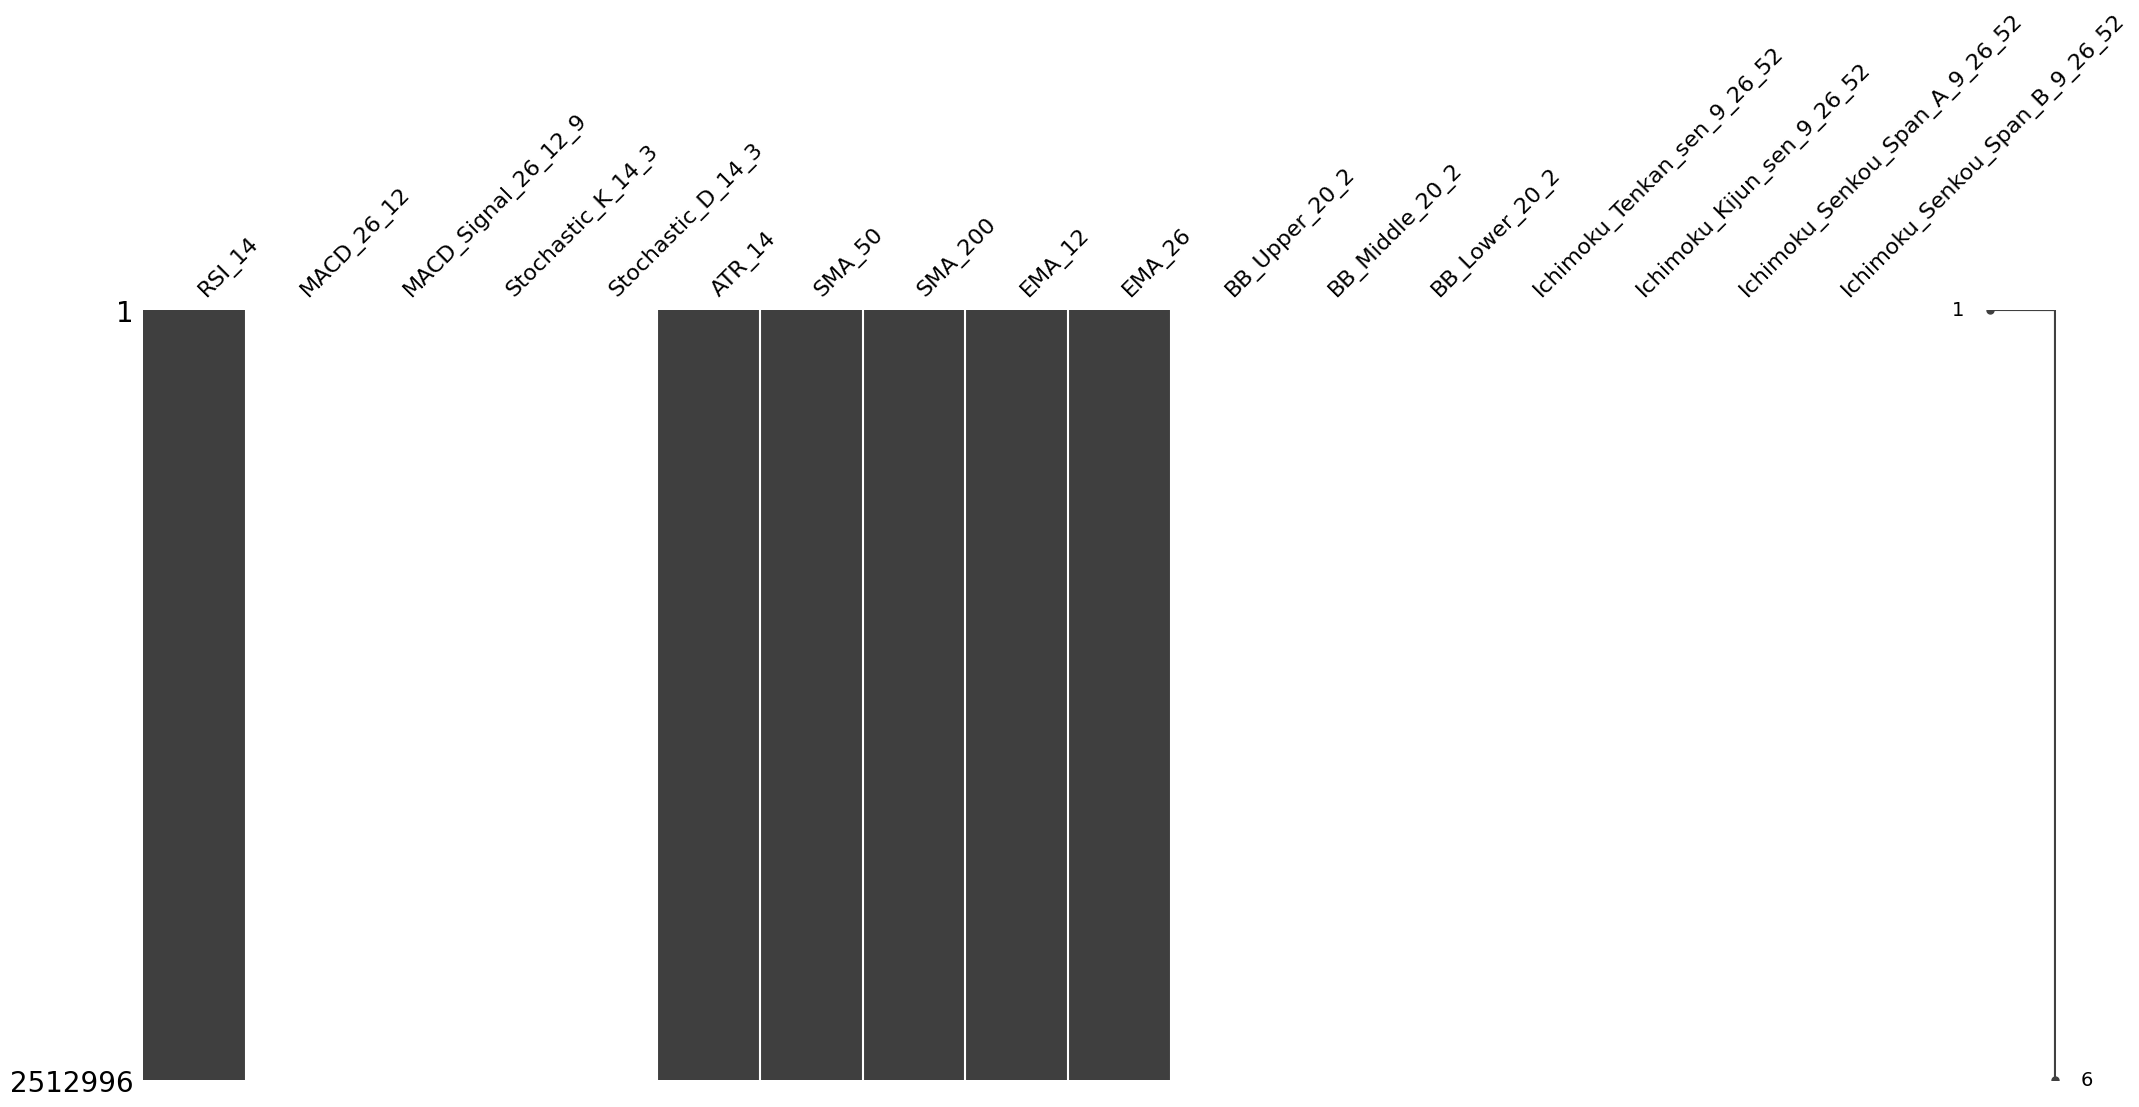

In [43]:
import missingno as msno

msno.matrix(df)

In [10]:
data['RSI_14'].describe()

count    2.512796e+06
mean    -1.826928e-05
std      2.516541e-02
min     -1.758891e+00
25%     -8.654203e-03
50%      0.000000e+00
75%      8.718671e-03
max      1.834213e+00
Name: RSI_14, dtype: float64

-5.011494771235454e-05


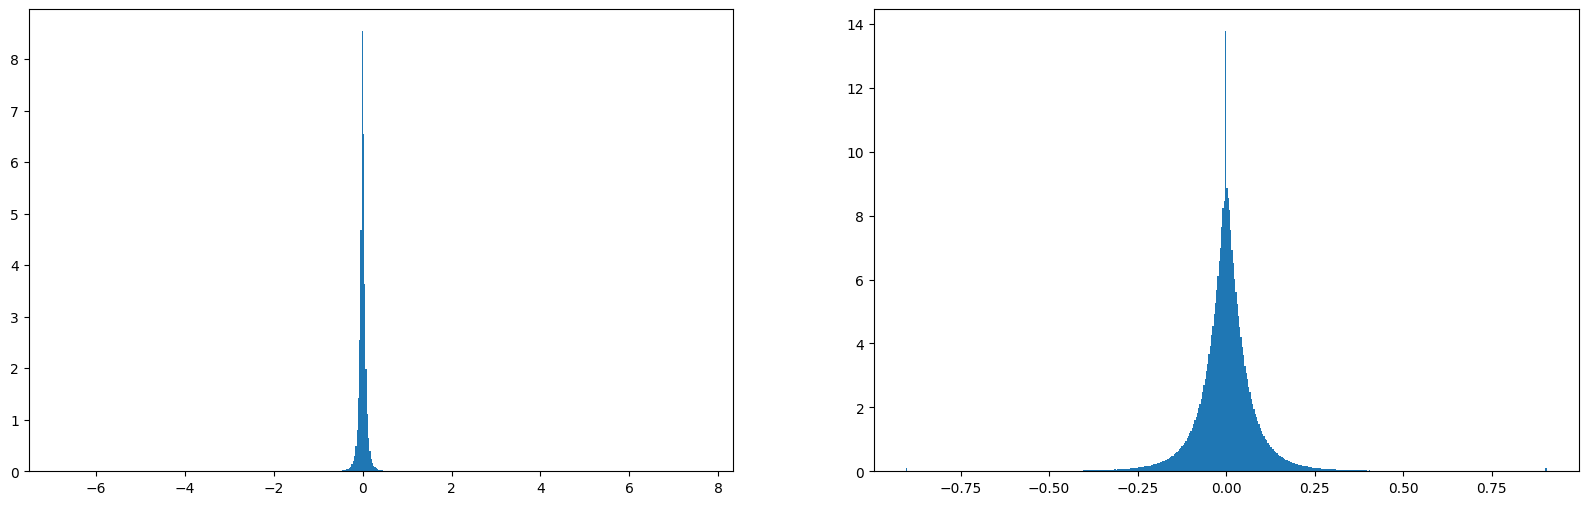

-2.2526365182315926e-05


In [7]:
quatiles_threshold = 0.0004

plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)    
plt.hist(data['Pct_change'] , bins=500, density=True)

data['Pct_change_cleaned'] = data['Pct_change'].clip(lower=data['Pct_change'].quantile(quatiles_threshold), upper=data['Pct_change'].quantile(1-quatiles_threshold))

print(data['Pct_change_cleaned'].mean())

data['Pct_change_cleaned'] = data['Pct_change_cleaned'] - data['Pct_change_cleaned'].mean()

plt.subplot(1, 2, 2)
plt.hist(data['Pct_change_cleaned'], bins=500, density=True)

plt.show()

print(data['Pct_change'].mean())

In [8]:
data = data.reindex(columns=['Pct_change_cleaned'] + columns[1:])
data

,Pct_change_cleaned,RSI_14,RSI_168,MACD_26/12,SMA_20,SMA_50,SMA_200,Boolinger_High,Boolinger_Low
Date,,,,,,,,,
2019-09-08 23:17:00,-0.016897,0.003626,0.000000,-5.680508,12.9235,20.3162,-107.97180,32.754275,-6.907275
2019-09-08 23:18:00,-0.040412,-0.003722,0.000000,-5.618211,10.2125,18.0302,-108.08920,30.263035,-9.838035
2019-09-08 23:19:00,-0.049196,0.009428,0.000000,-5.171931,4.9965,13.4276,-110.61570,23.963598,-13.970598
2019-09-08 23:20:00,0.010210,0.032904,0.000000,-4.357301,-0.9580,8.0928,-114.02675,16.158884,-18.074884
2019-09-08 23:21:00,-0.011753,-0.011425,0.000000,-3.753164,-0.7170,8.8268,-111.30305,14.636976,-16.070976
...,...,...,...,...,...,...,...,...,...
2024-06-18 23:08:00,-0.052982,0.013241,0.006335,55.845338,48.1650,-182.1940,-268.85850,171.406315,-75.076315
2024-06-18 23:09:00,-0.064964,-0.016589,-0.004636,52.731433,20.2900,-208.9180,-302.36150,123.573540,-82.993540
2024-06-18 23:10:00,-0.036142,0.026755,-0.007068,53.057219,-18.6850,-243.1500,-343.09300,83.014975,-120.384975


In [33]:
train_data, test_data = data[:int(len(data)*0.8)], data[int(len(data)*0.8):]

train_data = train_data.to_numpy()

test_data = test_data.to_numpy()

start_index = 0

train_target = train_target - train_target.mean()
# train_target = train_data[:, :1] - train_data[:, :1].mean()
train_data = train_data[:, start_index:]

test_target = test_data[:, :1]
test_data = test_data[:, start_index:]

In [34]:
def run_epoch(model, dataloader, optimizer, criterion):
    
    model.train()
    
    epoch_loss = 0

    batchs_number = len(dataloader)

    batchs = tqdm(enumerate(dataloader), unit='batch', total=batchs_number)
    for idx, (src, tgt_mask, tgt) in batchs:

        src = src.to(device)

        tgt = tgt.to(device)

        optimizer.zero_grad()

        out = model(src, tgt_mask.to(device))

        loss = criterion(out[...,0].contiguous(), tgt[...,0].contiguous())
        
        loss.backward()
        optimizer.step()
        epoch_loss += (loss.detach().item())

        if (idx + 5) % round(batchs_number/5) == 0:
            batchs.set_description('MSE {:.3E} '.format(
                epoch_loss/(idx+1)))

    return epoch_loss/batchs_number

In [35]:
def shift_sum(x):
    out = np.zeros((x.shape[0] + x.shape[1]-1))
    
    for k in range(x.shape[0]):
        out[k:k+x.shape[1]] += x[k]
        
    return out

In [36]:
def mean_absolute_error(x,y):
    return np.abs(x-y).mean().mean()

def mean_squared_error(x,y):
    return np.square(x-y).mean().mean()

torch2numpy = lambda x: x.cpu().detach().numpy()

pct_change = lambda x: (x[1:] - x[:-1])/x[:-1]

def eval_epoch(model, dataloader, points=0):

    prediction = []
    targets = []
    returns = []
    
    with torch.no_grad():
        for idx, (src, tgt_mask, tgt) in enumerate(dataloader):
            pred = model(src.to(device), tgt_mask.to(device))
            prediction.append(torch2numpy(pred[...,0]))
            targets.append(torch2numpy(tgt[...,0]))

    prediction = np.concatenate(prediction, axis=0)
    targets = np.concatenate(targets, axis=0)
    
    # prediction = shift_sum(prediction)/prediction.shape[1]
    # targets = shift_sum(targets)/targets.shape[1]
    
    mea = mean_absolute_error(targets, np.zeros(targets.shape))/mean_absolute_error(targets, prediction)
    mse = mean_squared_error(targets, np.zeros(targets.shape))/mean_squared_error(targets, prediction)
    returns = prediction * targets/np.abs(np.diff(prediction, axis=0)).mean()
    
    
    if points > 0:
        plt.figure(figsize=(14, 7))
        plt.plot(targets[-points:], label='True')
        plt.plot(prediction[-points:], label='Prediction')
        plt.legend()
        plt.figure(figsize=(14, 7))
        plt.plot(returns[-points:], label='Returns')
        plt.show()

    return  mse, mea, returns.mean()



In [37]:

def eval_epoch(model, dataloader, points=0):

    prediction = []
    targets = []
    returns = []
    
    with torch.no_grad():
        for idx, (src, tgt_mask, tgt) in enumerate(dataloader):
            pred = model(src.to(device), tgt_mask.to(device))
            prediction.append(torch2numpy(pred[...,0]))
            targets.append(torch2numpy(tgt[...,0]))

    prediction = np.concatenate(prediction, axis=0)
    targets = np.concatenate(targets, axis=0)
    
    # prediction = shift_sum(prediction)/prediction.shape[1]
    # targets = shift_sum(targets)/targets.shape[1]
    
    returns = prediction * targets
    
    norm = np.abs(np.diff(prediction, axis=0)).mean()
    normed_returns = returns/norm
    
    portfolio = np.cumsum(normed_returns)
    

    if points > 0:
        
        plt.figure(figsize=(14, 7))
        plt.subplot(2, 1, 1)
        plt.plot(targets[-points:], label='True')
        plt.plot(prediction[-points:], label='Prediction')
        plt.subplot(2, 1, 2)
        plt.plot(returns[-points:], label='Returns')
        plt.legend()
        plt.figure(figsize=(14, 7))
        plt.plot(portfolio, label='Portfolio')
        plt.show()

    return  normed_returns.mean(), norm, returns.mean()

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Conv1dCustom(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.stride = stride
        self.padding = padding

        # Simuler des données 2D pour nn.Unfold : (C, L) -> (C, 1, L)
        self.unfold = nn.Unfold(kernel_size=(1, kernel_size), stride=(1, stride), padding=(0, padding))

        # La taille du kernel déplié correspond au nombre de canaux d'entrée multiplié par la taille du kernel
        kernel_size_flat = in_channels * kernel_size
        self.linear = nn.Linear(kernel_size_flat, out_channels)
        self.linear_mean = nn.Linear(in_channels, out_channels, bias=False)
        self.kernel_size = kernel_size
        self.in_channels = in_channels

    def forward(self, x):
        # x shape : (batch_size, in_channels, length)
        # Ajouter une dimension factice pour hauteur
        x = x.unsqueeze(2)  # Nouvelle shape : (batch_size, in_channels, 1, length)
        
        # Utiliser unfold pour transformer l'entrée en une série de fenêtres à traiter
        # x_unfolded shape : (batch_size, in_channels * kernel_size, L), où L est le nombre total de ces fenêtres
        x = self.unfold(x)
        
        x = x.reshape(x.shape[0], self.in_channels, self.kernel_size, -1).mean(dim=2)
         
        x_mean = x.mean(dim=2, keepdim=True)
        
        x = x - x_mean
        
        x = x.reshape(x.shape[0], self.in_channels * self.kernel_size, -1)
        
        # Appliquer la couche linéaire à chaque fenêtre
        # x_conv shape après linear : (batch_size, L, out_channels)
        x_conv = self.linear(x.transpose(1, 2))
        
        x_mean = self.linear_mean(x_mean.transpose(1, 2))
        
        x_conv = x_conv + x_mean
        
        # Remodeler la sortie pour qu'elle ait le format attendu : (batch_size, out_channels, length')
        # Où length' est calculée en fonction du stride, du padding, et de la taille du kernel
        out_length = (x.size(-1) + 2 * self.padding - self.kernel_size) // self.stride + 1
        x_conv = x_conv.transpose(1, 2).contiguous().view(-1, self.linear.out_features, out_length)
        
        return x_conv

    
        
    
class CNN(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config['hidden_size']
        self.pred_len = config['pred_len']
        self.input_size = config['input_size']
        self.output_size = config['output_size']
        
        layer = Conv1dCustom
        
        self.conv = nn.ModuleList([layer(self.input_size if i == 0 else self.hidden_size, self.hidden_size, 3, padding=1) for i in range(3)])
        self.conv_stride = nn.ModuleList([layer(self.hidden_size, self.hidden_size, 3, padding=1, stride=3) for i in range(3)])
        
        self.linear = nn.Linear(self.hidden_size, self.pred_len)
        

    def forward(self, input_seq, tgt):
        
        input_seq = input_seq.permute(0,2,1)
        
        for i in range(3):
            
            input_seq = self.conv[i](input_seq)
            input_seq = self.conv_stride[i](input_seq)

        return self.linear(input_seq[:, :, 0]).unsqueeze(-1)

In [39]:
class ResNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.num_layers = config['num_layers'] * 2 -1
        self.hidden_size = config['hidden_size']
        self.pred_len = config['pred_len']
        self.input_size = config['input_size']
        self.output_size = config['output_size']
        
        self.preconv = nn.Conv1d(self.input_size, 8, 3, padding=1)
        
        self.conv1 = nn.ModuleList([nn.Conv1d(8, 8, 3, padding=1) for i in range(self.num_layers)])
        
        self.stride1 = nn.Conv1d(8, 16, 3, padding=1, stride=2) # 32 -> 16
        
        self.conv2 = nn.ModuleList([nn.Conv1d(16, 16, 3, padding=1) for i in range(self.num_layers)])
        
        self.stride2 = nn.Conv1d(16, 32, 3, padding=1, stride=2) # 16 -> 8
        
        self.conv3 = nn.ModuleList([nn.Conv1d(32, 32, 3, padding=1) for i in range(self.num_layers)])
        
        self.stride3 = nn.Conv1d(32, 64, 3, padding=1, stride=2) # 8 -> 4
        
        self.lin1 = nn.Linear(64 * 2 , 32)
        
        self.lin2 = nn.Linear(32, self.pred_len)
        
        self.tanh = nn.Tanh()
        
        self.avgpool = nn.AvgPool1d(2)
        

    def forward(self, input_seq, tgt):
        
        input_seq = input_seq.permute(0,2,1)
        
        x = self.preconv(input_seq)
        x = self.tanh(x)
        
        x_conv = x
        
        for i in range(self.num_layers):
            
            x_conv = self.tanh(self.conv1[i](x_conv))
            if i % 2 == 0:
                x_conv = x_conv + x
                x = x_conv
                
        x = self.avgpool(x).repeat(1,2,1)
        
        x_conv = self.stride1(x_conv)
        

        for i in range(self.num_layers):
            
            x_conv = self.tanh(self.conv2[i](x_conv))
            if i % 2 == 1:
                x_conv = x_conv + x
                x = x_conv
                
        x = self.avgpool(x).repeat(1,2,1)
        
        x_conv = self.stride2(x_conv)
        
        for i in range(self.num_layers):
                
                x_conv = self.tanh(self.conv3[i](x_conv))
                if i % 2 == 0:
                    x_conv = x_conv + x
                    x = x_conv
        
        x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.lin1(x)
        
        return self.lin2(self.tanh(x)).unsqueeze(-1)    


In [40]:
class DiffConv(nn.Module):
    def __init__(self, config):
        super(DiffConv, self,).__init__()
        self.hidden_size = config['hidden_size']
        self.pred_len = config['pred_len']
        self.input_size = config['input_size']
        self.output_size = config['output_size']
        
        self.preconv = nn.Conv2d(self.input_size, 8, 3)
        
        
        # self.conv1 = nn.Conv2d(8, 8, 3, padding=1)
        
        
        # self.conv_stride1 = nn.Conv2d(8, 16, 3, padding=1, stride=3) #27 -> 9
        # self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        
        # self.conv_stride2 = nn.Conv2d(16, 32, 3, padding=1, stride=3) #9 -> 3
        # self.conv3 = nn.Conv2d(32, 64, 3) #3 -> 
        
        self.conv1 = nn.ModuleList([nn.Conv2d(8, 8, 3, padding=1) for i in range(3)])
        
        self.conv_stride1 = nn.Conv2d(8, 16, 3, padding=1, stride=3) #27 -> 9
        
        self.conv2 = nn.ModuleList([nn.Conv2d(16, 16, 3, padding=1) for i in range(3)])
        
        self.conv_stride2 = nn.Conv2d(16, 32, 3, padding=1, stride=3) #9 -> 3
        
        self.conv3 = nn.ModuleList([nn.Conv2d(32, 32, 3, padding=1) for i in range(3)])
        
        self.linear = nn.Linear(32, self.pred_len)


    def forward(self, x, tgt=None):
        
        B, L, C = x.shape
        
        x = x.permute(0, 2, 1).reshape(B, C, L, 1)
        
        diffx = x.repeat(1, 1, 1, L)
        
        diffx = diffx.transpose(-2,-1) - diffx
        
        
        diffx = self.preconv(diffx)

        for i in range(3):
            res = diffx
            diffx = self.conv1[i](diffx)
            diffx = diffx + res
            
        
                
        
        diffx = self.linear(diffx.squeeze())
        
        return diffx.unsqueeze(-1)
        
        


In [41]:
class NomalisationEnvelope(nn.Module):
    def __init__(self, core, config, norm=True, use_only_tgt=False):
        super(NomalisationEnvelope, self).__init__()
        self.core = core(config)
        self.norm = norm
        self.use_only_tgt = use_only_tgt
        if norm:
            self.w = nn.Parameter(torch.ones(config.input_size))
            self.register_parameter('w', self.w)
            self.b = nn.Parameter(torch.zeros(config.input_size))
            self.register_parameter('b', self.b)
        
    def forward(self, src, tgt = None):

        seq_last = src[:,-1:,:].detach()
        

        if self.use_only_tgt:
            src = src - seq_last[:,:,:1]
            tgt = tgt - seq_last[:,:,:1]
        else:
            src = src - seq_last
            tgt = tgt - seq_last
        

            
        if self.norm:
            src = src*self.w + self.b
            tgt = tgt*self.w + self.b

        out = self.core(src, tgt)

        if self.norm:
            out = (out - self.b)/self.w
  
        out = out + seq_last

        return out

In [42]:
class LSTM(nn.Module):
    def __init__(self, config):
        super(LSTM, self).__init__()
        self.hidden_size = config['hidden_size']
        self.pred_len = config['pred_len']
        self.input_size = config['input_size']
        self.output_size = config['output_size']
        self.num_layers = config['num_layers']
        
        self.norm = nn.Parameter(torch.ones(1,1,self.input_size))
        self.norm_b = nn.Parameter(torch.zeros(1,1,self.input_size))
        
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=0.2)
        self.linear = nn.Linear(self.hidden_size, self.pred_len)
        

    def forward(self, input_seq, tgt = None):
        
        input_seq = torch.concat([input_seq[:, -1:, :1], input_seq[:, -1:, 1:]-input_seq[:, -1:, 1].unsqueeze(-1)], dim=-1)
        
        input_seq = input_seq*self.norm + self.norm_b
        
        lstm_out, _ = self.lstm(input_seq)
        lstm_out = self.linear(lstm_out[:, -1, :])
        
        
        return lstm_out.unsqueeze(-1).tanh()

In [43]:
class EMBLSTM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config['hidden_size']
        self.pred_len = config['pred_len']
        self.input_size = config['input_size']
        self.output_size = config['output_size']
        self.num_layers = config['num_layers']
        
        self.norm = nn.Parameter(torch.ones(1,1,self.input_size))
        self.norm_b = nn.Parameter(torch.zeros(1,1,self.input_size))
        
        self.embedding = nn.Linear(self.input_size, self.hidden_size)
        self.activation = nn.LeakyReLU()
        
        
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=0.2)
        self.linear = nn.Linear(self.hidden_size, self.pred_len)
        

    def forward(self, input_seq, tgt = None):
        
        # input_seq = input_seq-input_seq[:, -1:, :1]
        
        input_seq = input_seq*self.norm + self.norm_b
        
        input_seq = self.activation(self.embedding(input_seq))
        
        lstm_out, _ = self.lstm(input_seq)
        lstm_out = self.linear(lstm_out[:, -1, :])
        
        
        return lstm_out.unsqueeze(-1).tanh()

In [44]:
class NormLSTM(nn.Module):
    def __init__(self, config):
        super(NormLSTM, self).__init__()
        self.hidden_size = config['hidden_size']
        self.pred_len = config['pred_len']
        self.input_size = config['input_size']
        self.output_size = config['output_size']
        self.num_layers = config['num_layers']
        
        self.layer_norm = nn.LayerNorm(self.input_size)
        
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=0.2)
        self.linear = nn.Linear(self.hidden_size, self.pred_len)
        

    def forward(self, input_seq, tgt = None):
        
        # input_seq = input_seq-input_seq[:, -1:, :1]
        
        input_seq = self.layer_norm(input_seq)
        
        lstm_out, _ = self.lstm(input_seq)
        lstm_out = self.linear(lstm_out[:, -1, :])
        
        
        return lstm_out.unsqueeze(-1).tanh()

In [45]:
class CNN(nn.Module):
    def __init__(self, config):
        super(CNN, self).__init__()
        self.hidden_size = config['hidden_size']
        self.pred_len = config['pred_len']
        self.input_size = config['input_size']
        self.output_size = config['output_size']
        self.num_layers = config['num_layers']
        
        self.kernel = 3
        
        self.preconv = nn.Conv1d(self.input_size, 8, self.kernel)
        
        self.convs1 = nn.ModuleList([nn.Conv1d(8, 8, self.kernel, padding=1) for i in range(self.num_layers)])
        
        self.stride1 = nn.Conv1d(8, 16, self.kernel, stride=3)
        
        self.convs2 = nn.ModuleList([nn.Conv1d(16, 16, self.kernel, padding=1) for i in range(self.num_layers)])
        
        self.stride2 = nn.Conv1d(16, 32, self.kernel, stride=3)
        
        self.mlp = nn.ModuleList([nn.Linear(3*32, 3*32) for i in range(self.num_layers)])
        
        self.linear = nn.Linear(3*32, self.pred_len)
        self.tanh = nn.Tanh()
        

    def forward(self, input_seq, tgt = None):
        
        input_seq = input_seq.permute(0,2,1)
        
        x = self.preconv(input_seq)
        
        for i in range(self.num_layers):
                
            x = self.tanh(self.convs1[i](x))
        
        x = self.stride1(x)
        
        for i in range(self.num_layers):
                    
            x = self.tanh(self.convs2[i](x))
            
        
            
        x = self.stride2(x)

        
        x = x.view(x.size(0), -1)
        
        for i in range(self.num_layers):
            
            x = self.tanh(self.mlp[i](x))
            
        return self.linear(x).unsqueeze(-1)

In [46]:
from utils.tools import AttrDict, get_config


config = {
    # data
 'seq_len': 29,
 'pred_len': 1,
 'batch_size': 32*2,
 'shuffle': True,
 'output_size': train_data.shape[1],
 'offset': 0,
 
    # model

 'model': LSTM,
 'envelope': NomalisationEnvelope,
 'input_size': train_data.shape[1],
 'hidden_size': 64,
 'num_layers': 2,
 'dropout': 0.0,
 'bidirectional': False,
 
 # Training
 
  'num_epochs': 10,
 'lr': 1e-4,
 'max_grad_norm': 0.1,
 'gamma': 0.2,
 'patience': 10,
 'cd': 0,
 }

config = AttrDict(config)

In [47]:
from dataset.dataset import TimeSeriesDataset
from torch.utils.data import DataLoader

train_dataset = TimeSeriesDataset(train_data, config.seq_len, config.pred_len, config.offset, multi_tgt=True, tgt=train_target)

train_dataloader = DataLoader(
    train_dataset, config.batch_size, shuffle=config.shuffle, pin_memory=False)

train_dataloader_infer = DataLoader(
    train_dataset, config.batch_size, shuffle=False)

val_dataset = TimeSeriesDataset(test_data, config.seq_len, config.pred_len, config.offset, multi_tgt=True, tgt=test_target)

val_dataloader = DataLoader(val_dataset, config.batch_size, shuffle=False)

In [48]:
class ExpInvestLoss(nn.Module):
    def __init__(self, alpha=0.1):
        super(ExpInvestLoss, self).__init__()
        self.alpha = alpha

    def forward(self, y_pred, y_true):
        
        return torch.exp(-y_true*y_pred*self.alpha).mean()
    
class InvestLoss(nn.Module):
    def __init__(self, alpha=0):
        super(InvestLoss, self).__init__()
        self.alpha = alpha
    def forward(self, y_pred, y_true):
        
        return (-y_true*y_pred).mean()/y_pred.abs().mean()**self.alpha

In [49]:
import torch.nn as nn



model = LSTM(config).to(device)

# model = DiffConv(config).to(device)

# model = Model(config).to(device)

# criterion = nn.HuberLoss(delta=1)
# criterion = nn.L1Loss()
# criterion = nn.MSELoss()
criterion = InvestLoss(0)
# criterion = ExpInvestLoss(4)



optimizer = torch.optim.Adam(model.parameters(), config.lr, amsgrad=True)


train_history = []
val_history = []

  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/6229 [00:00<?, ?batch/s]

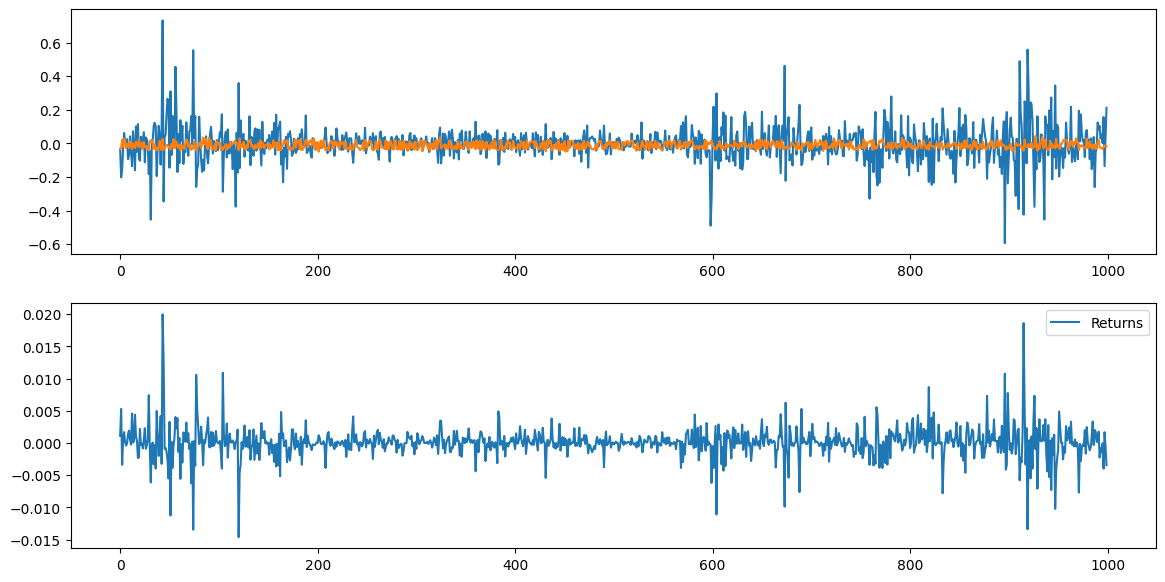

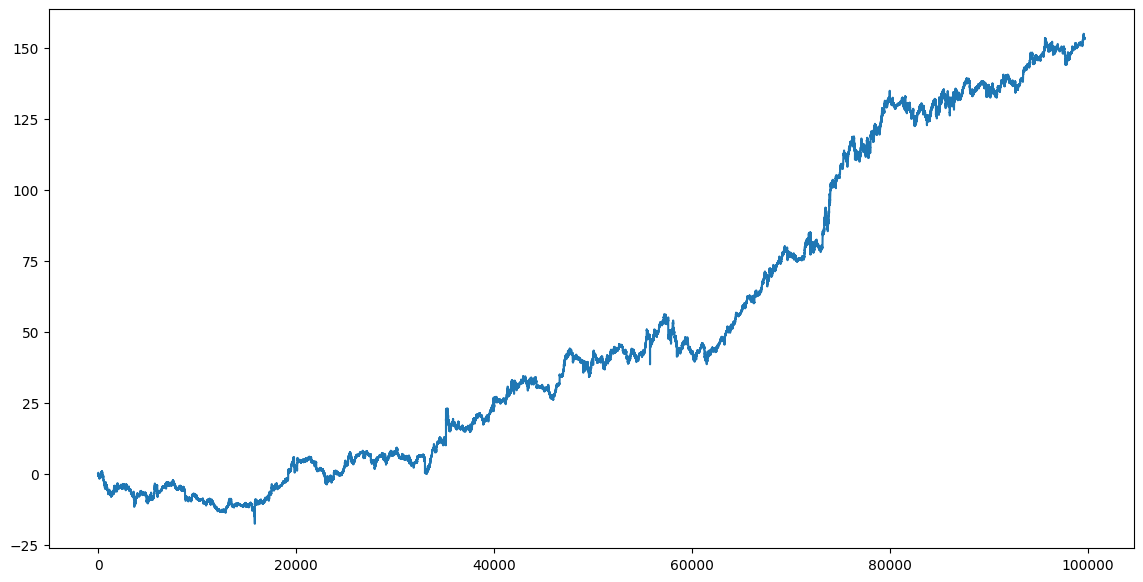

##### TRAIN socre 3.0261E-03 norm 2.4431E-02 r: 7.3932E-05 VALIDATION score 1.5373E-03 norm 2.3437E-02 r: 3.6031E-05 #####


  0%|          | 0/6229 [00:00<?, ?batch/s]

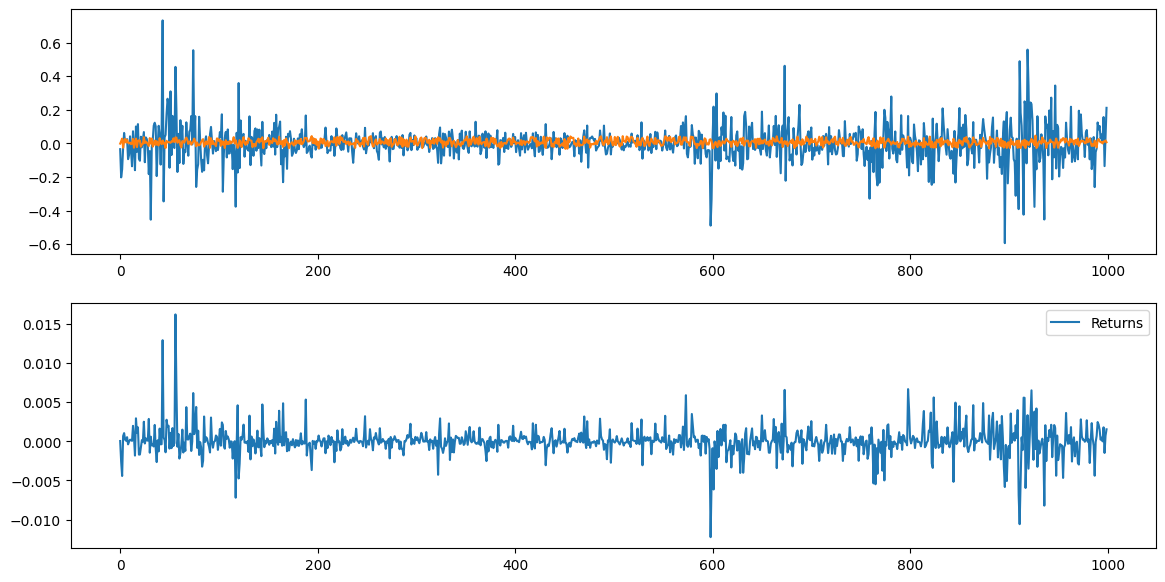

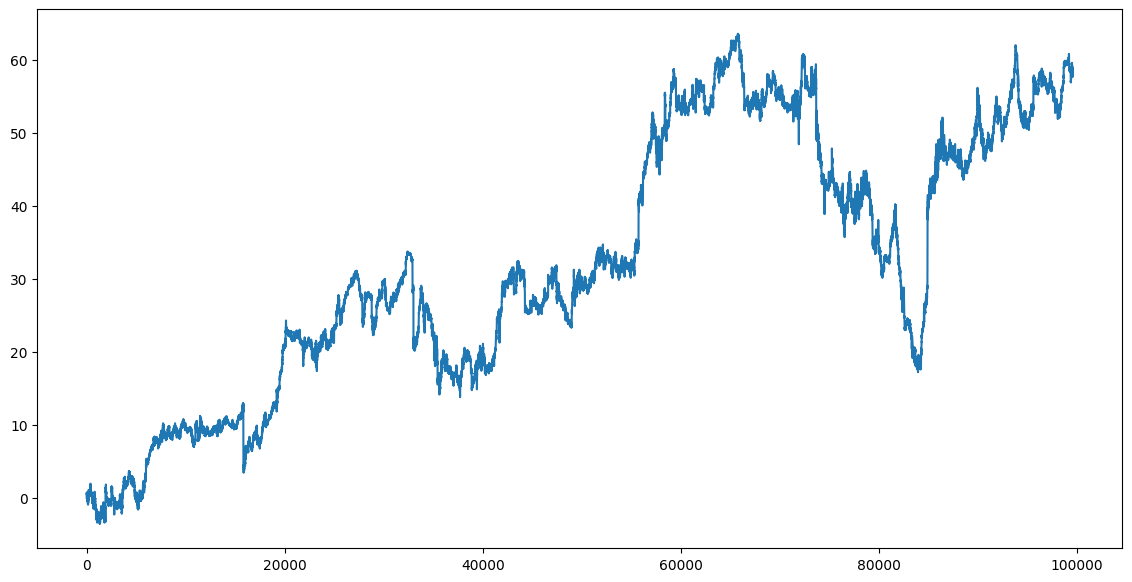

##### TRAIN socre 2.9934E-03 norm 2.1707E-02 r: 6.4976E-05 VALIDATION score 5.8529E-04 norm 2.0736E-02 r: 1.2137E-05 #####


  0%|          | 0/6229 [00:00<?, ?batch/s]

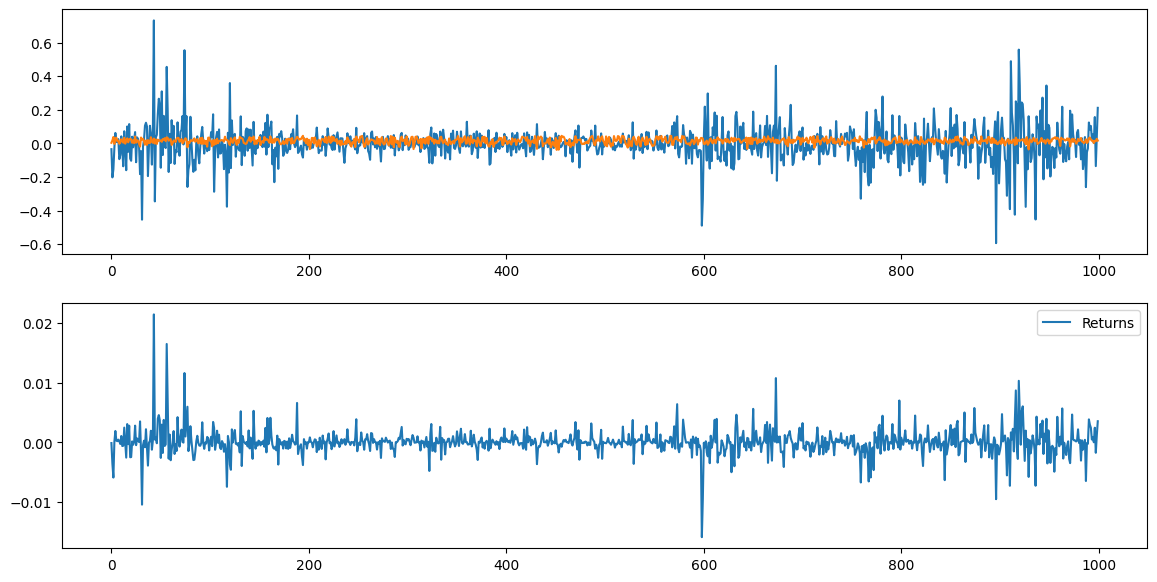

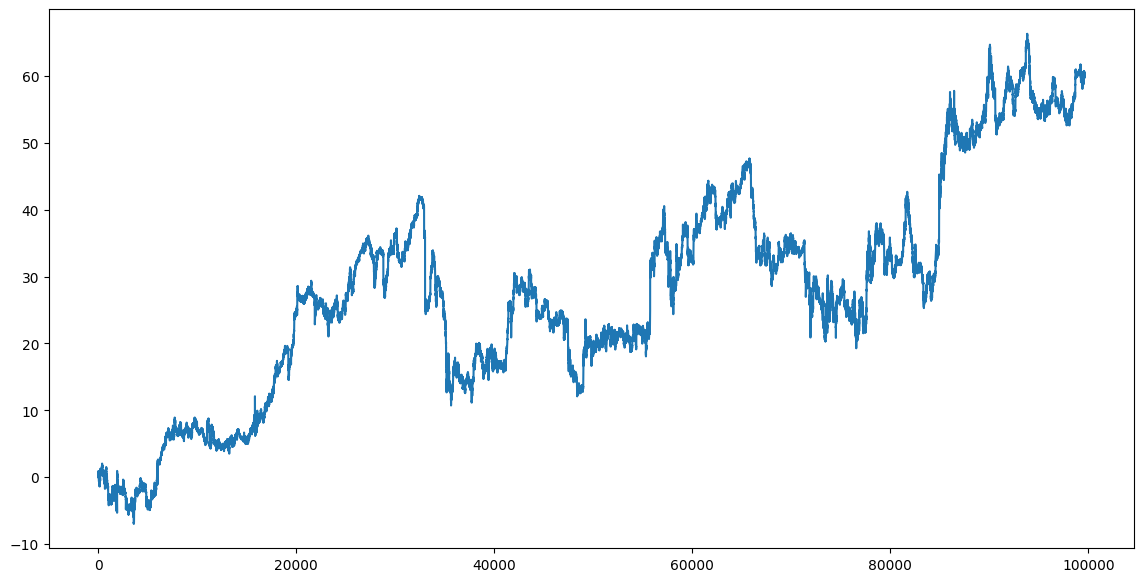

##### TRAIN socre 3.2686E-03 norm 2.1970E-02 r: 7.1809E-05 VALIDATION score 6.0731E-04 norm 2.0187E-02 r: 1.2260E-05 #####


  0%|          | 0/6229 [00:00<?, ?batch/s]

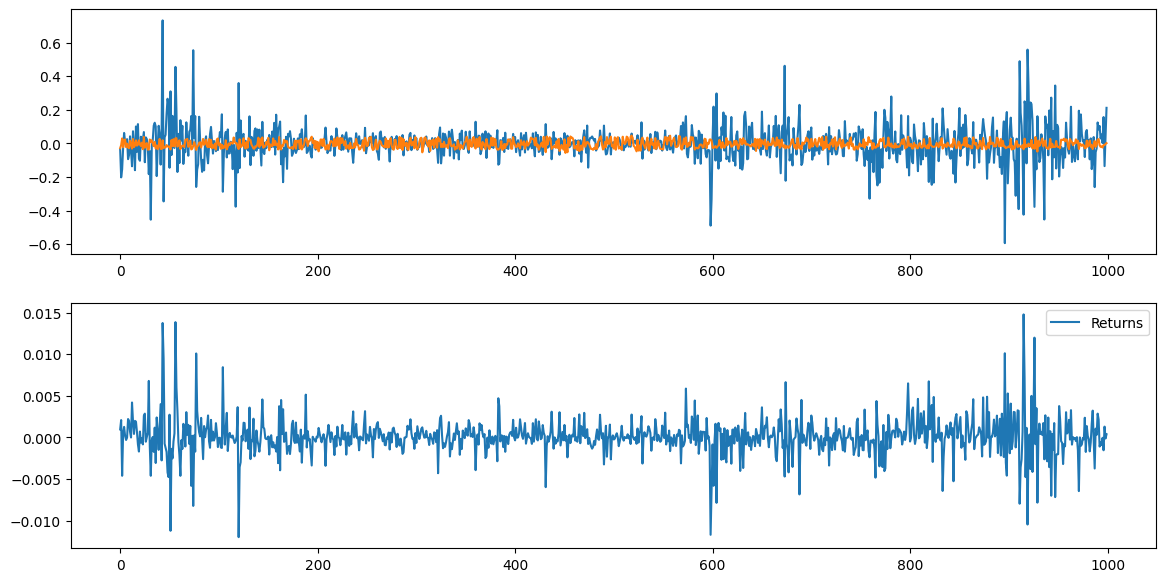

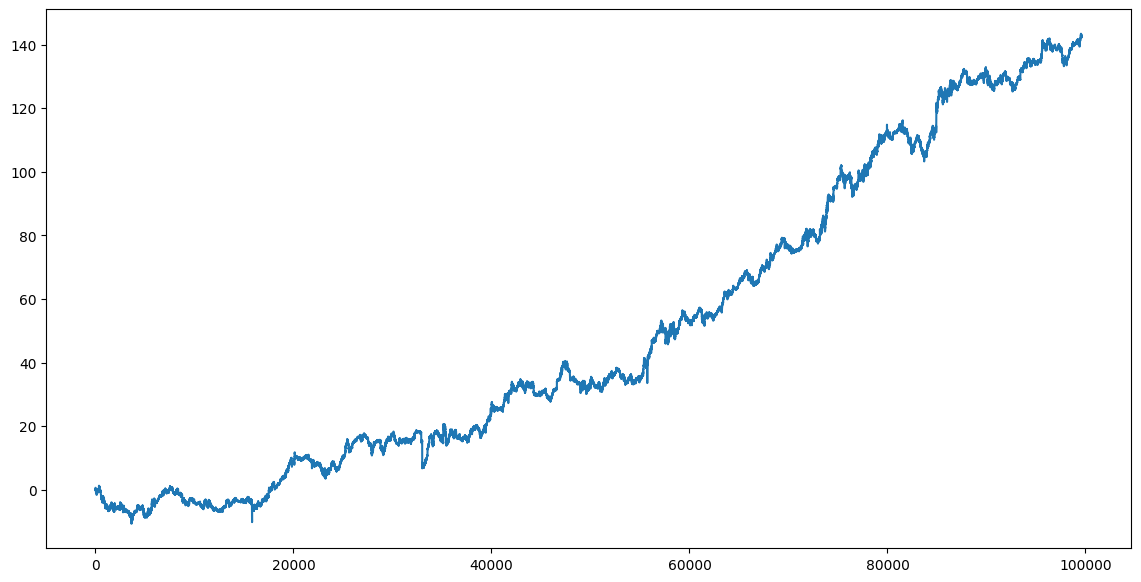

##### TRAIN socre 3.4545E-03 norm 3.0152E-02 r: 1.0416E-04 VALIDATION score 1.4297E-03 norm 2.8054E-02 r: 4.0109E-05 #####


  0%|          | 0/6229 [00:00<?, ?batch/s]

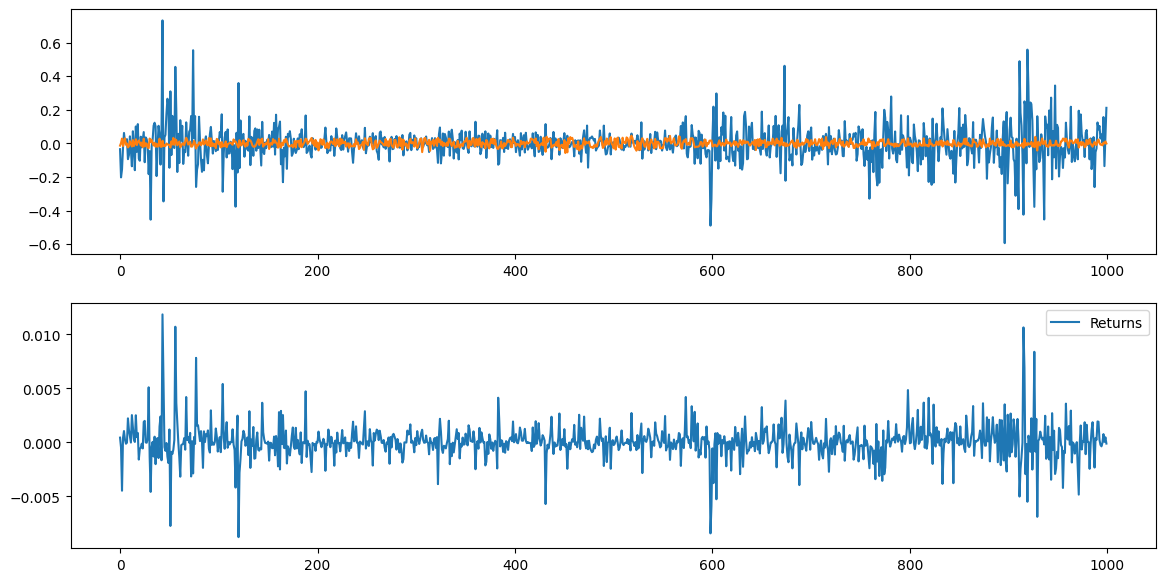

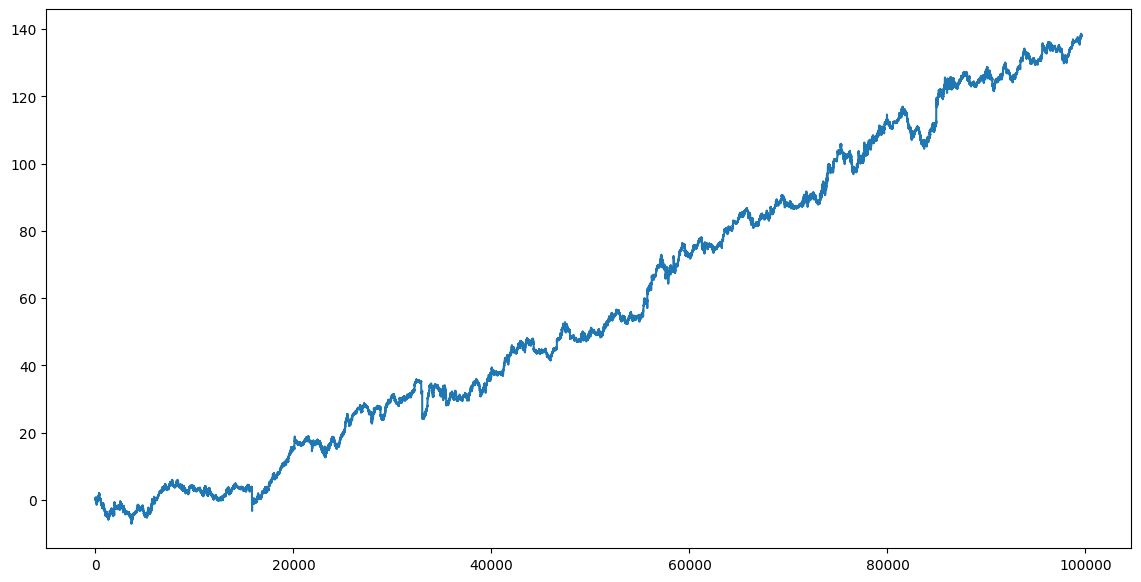

##### TRAIN socre 3.7161E-03 norm 2.5066E-02 r: 9.3148E-05 VALIDATION score 1.3860E-03 norm 2.2702E-02 r: 3.1465E-05 #####


  0%|          | 0/6229 [00:00<?, ?batch/s]

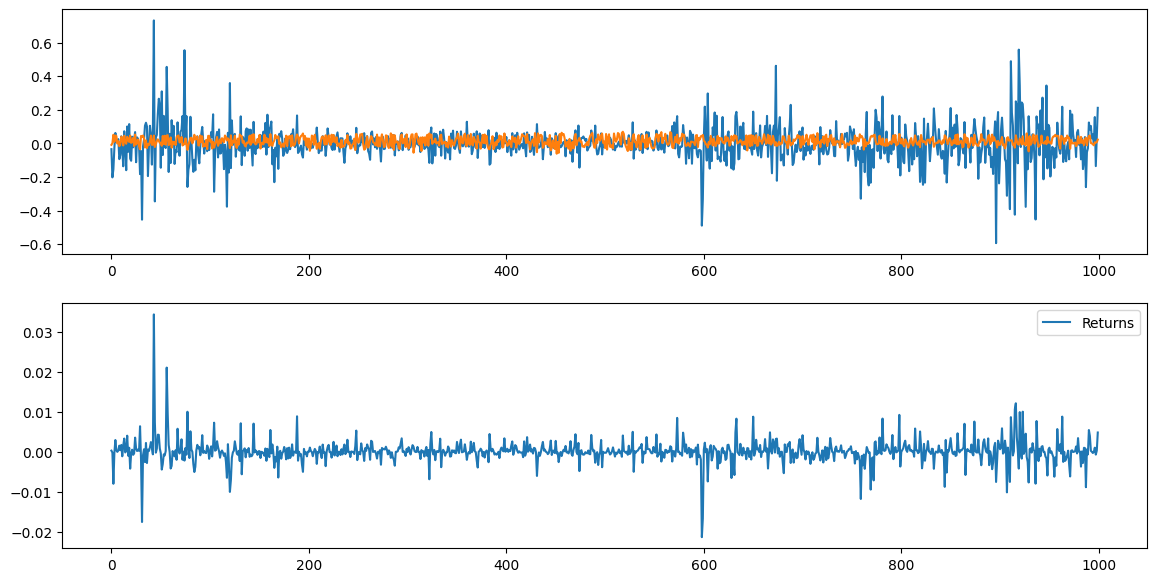

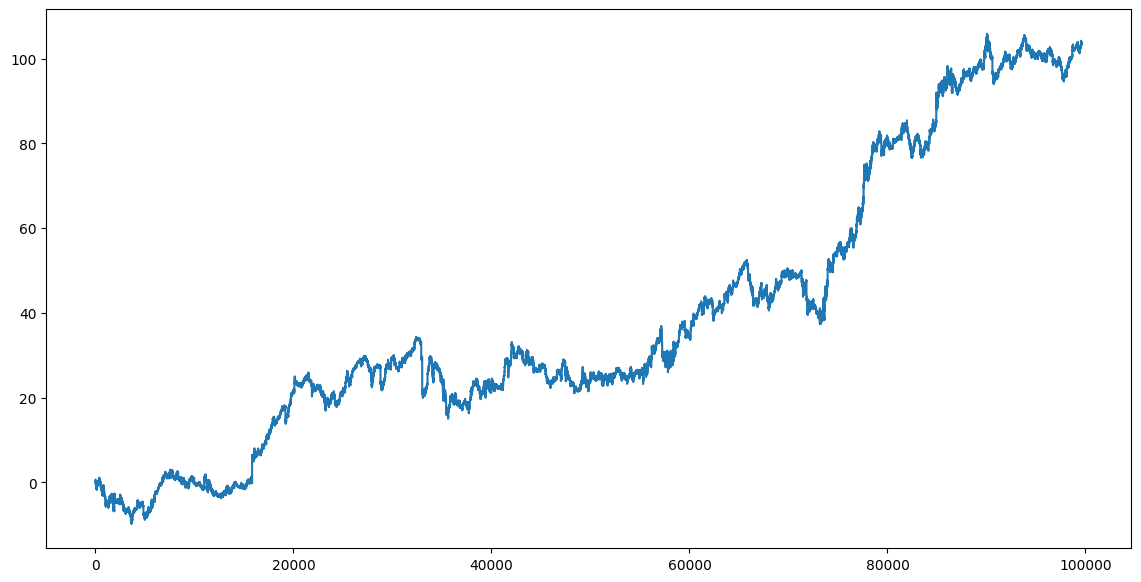

##### TRAIN socre 3.6294E-03 norm 3.5697E-02 r: 1.2956E-04 VALIDATION score 1.0400E-03 norm 3.2918E-02 r: 3.4234E-05 #####


  0%|          | 0/6229 [00:00<?, ?batch/s]

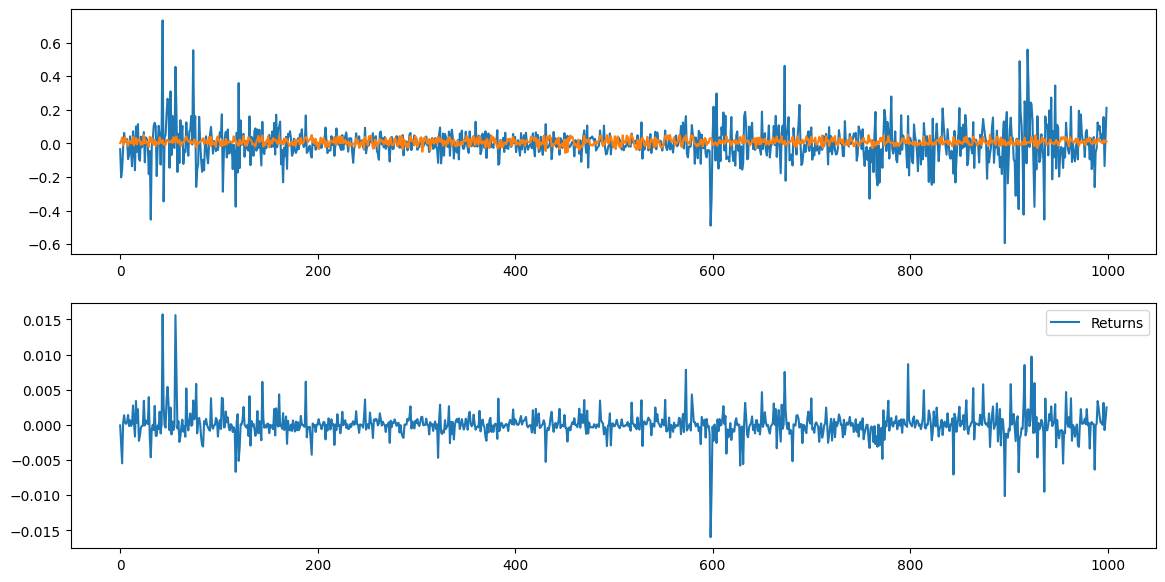

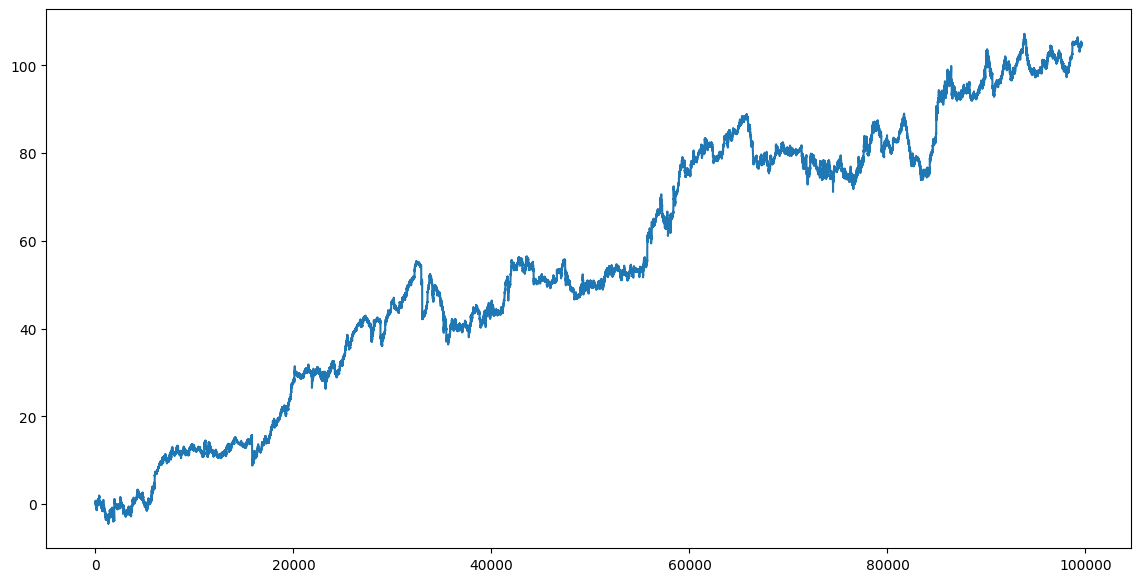

##### TRAIN socre 4.1633E-03 norm 2.5599E-02 r: 1.0657E-04 VALIDATION score 1.0537E-03 norm 2.3533E-02 r: 2.4797E-05 #####


  0%|          | 0/6229 [00:00<?, ?batch/s]

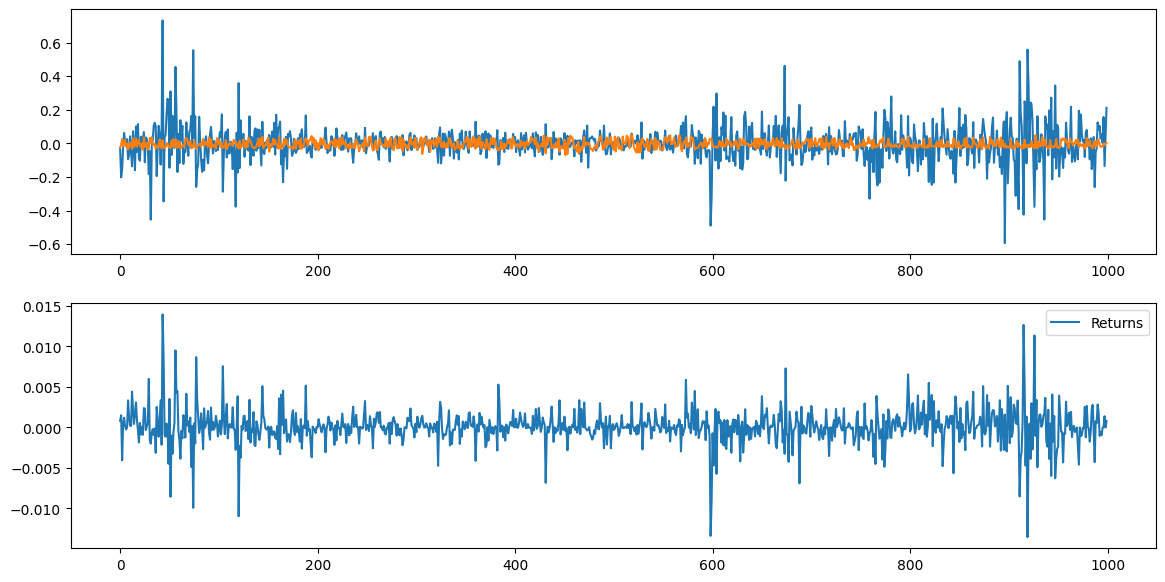

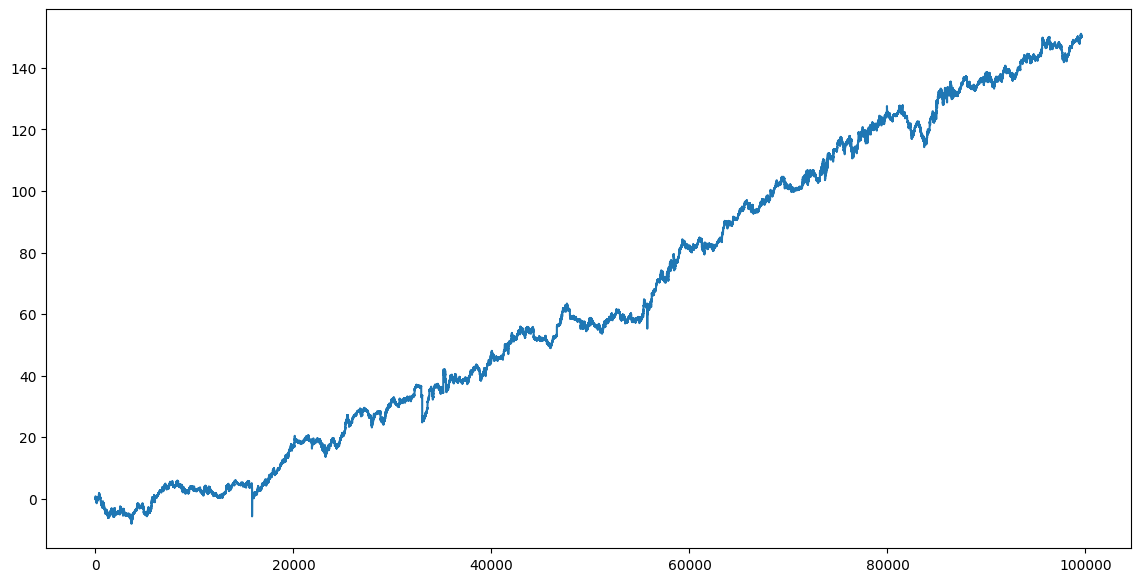

##### TRAIN socre 4.3833E-03 norm 3.0437E-02 r: 1.3341E-04 VALIDATION score 1.5085E-03 norm 2.8081E-02 r: 4.2361E-05 #####


  0%|          | 0/6229 [00:00<?, ?batch/s]

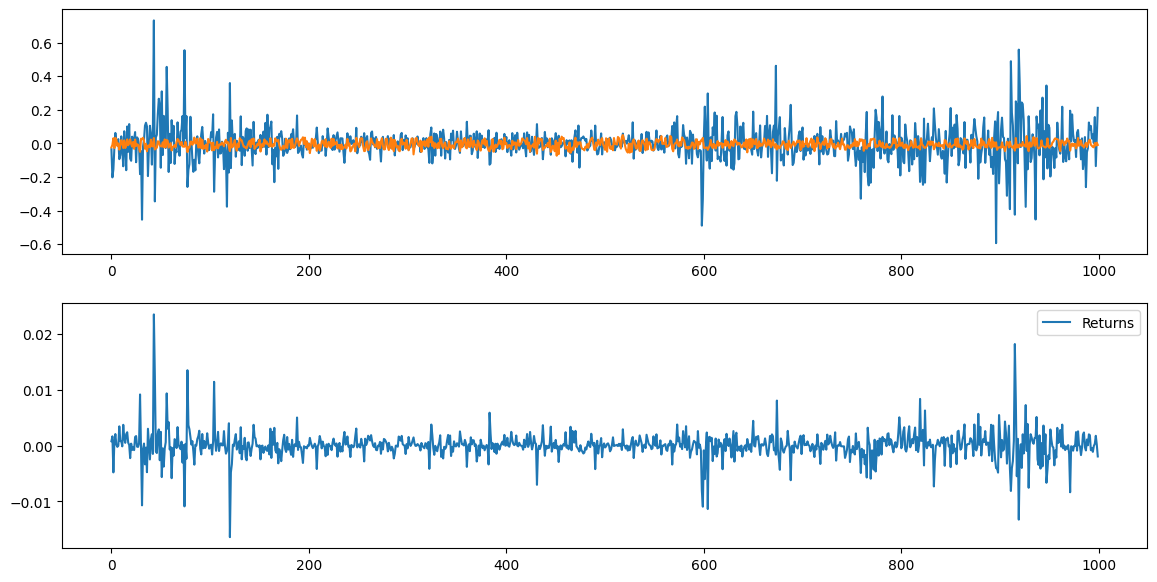

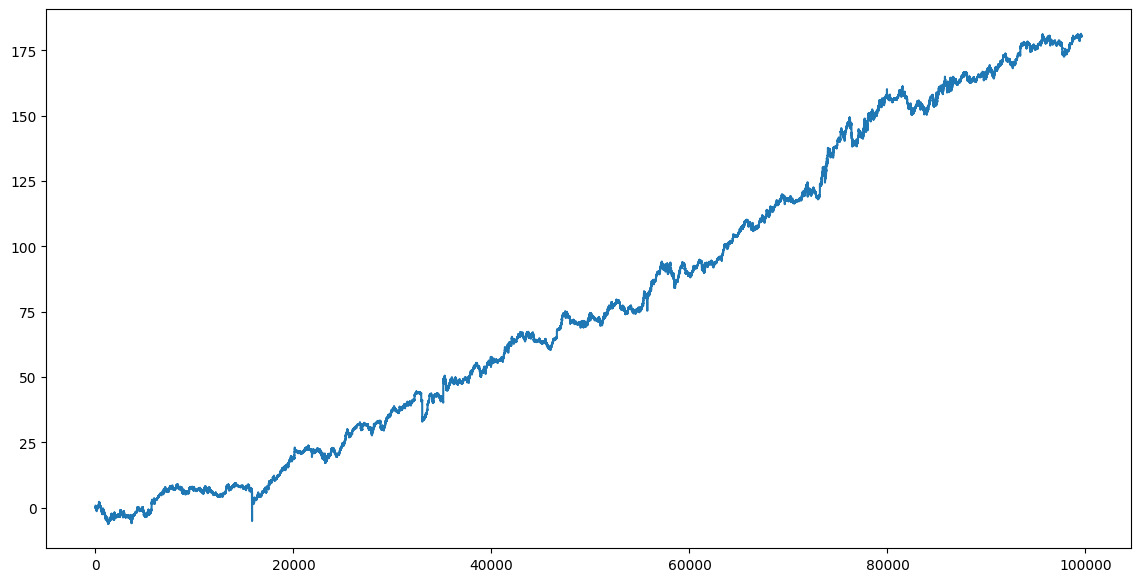

##### TRAIN socre 4.7617E-03 norm 3.0200E-02 r: 1.4380E-04 VALIDATION score 1.8117E-03 norm 2.7833E-02 r: 5.0423E-05 #####


  0%|          | 0/6229 [00:00<?, ?batch/s]

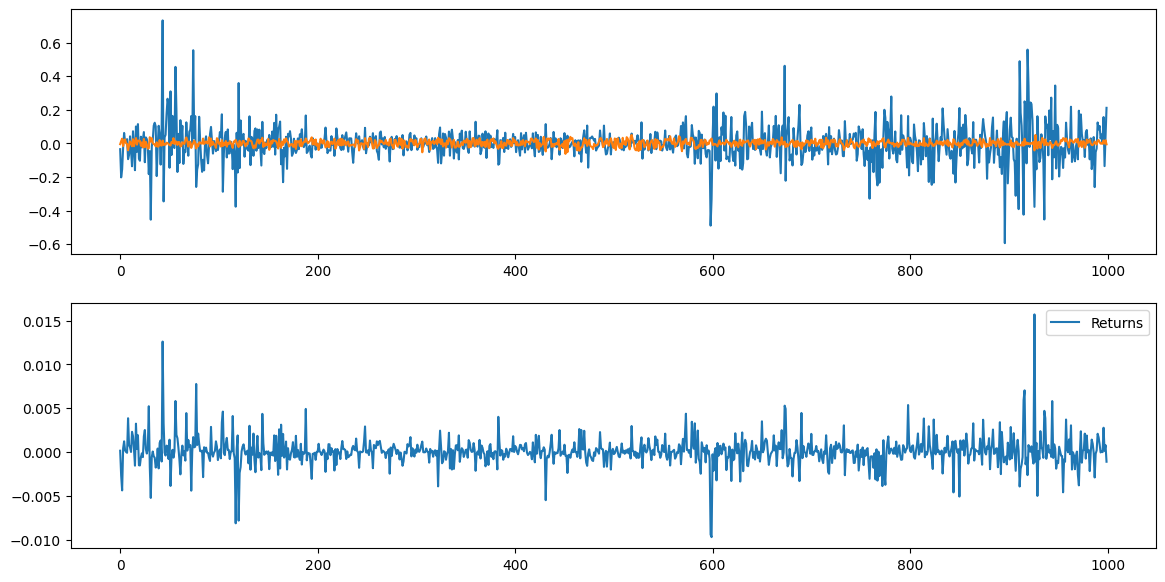

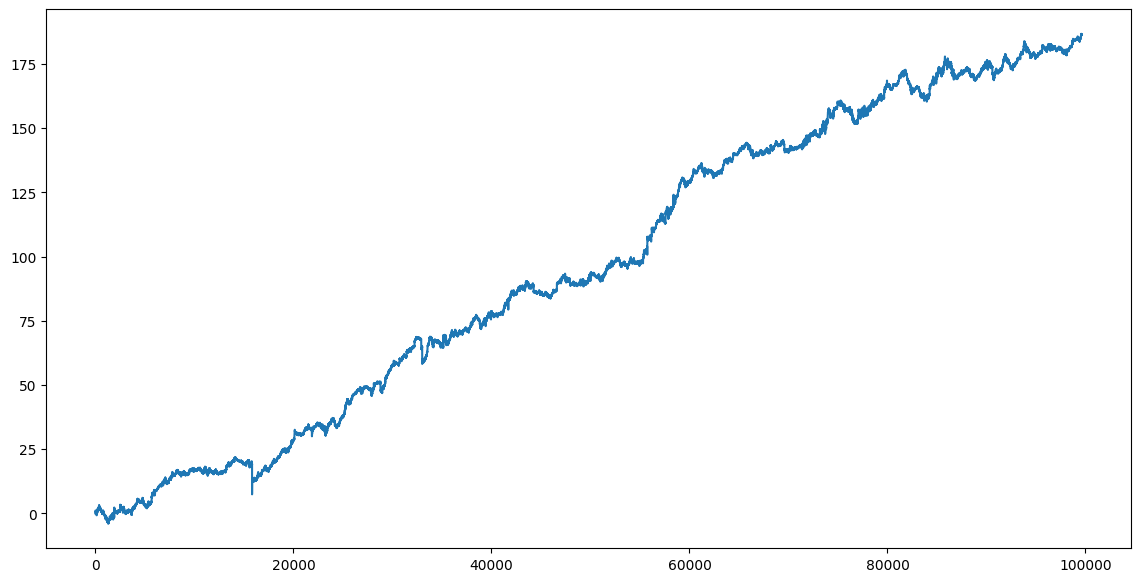

##### TRAIN socre 5.5415E-03 norm 2.4452E-02 r: 1.3550E-04 VALIDATION score 1.8723E-03 norm 2.2422E-02 r: 4.1979E-05 #####


In [50]:
epoch = tqdm(range(config.num_epochs), unit='epoch')

for e in epoch:
    model.train()
    loss = run_epoch(
        model, train_dataloader, optimizer, criterion)

    model.eval()

    train_history.append(eval_epoch(model, train_dataloader_infer))

    val_history.append(eval_epoch(model, val_dataloader, points=1000))
    

    print('##### TRAIN socre {:.4E} norm {:.4E} r: {:.4E} VALIDATION score {:.4E} norm {:.4E} r: {:.4E} #####'.format(*train_history[-1], *val_history[-1]))

    # epoch.set_description(
    #     '##### Train SCOREdata.shape[1] {:.4E}  Validation SCORE {:.4E}  #####'.format(train_score, validation_score))

##### LSTM 10 epoch TRAIN mse 9.9804E-01 mae 9.9112E-01 r: 0.0000E+00 VALIDATION mse 1.0025E+00 mae 9.9044E-01 r: 0.0000E+00 #####
##### CNN TRAIN mse 9.9705E-01 mae 9.9150E-01 r: 0.0000E+00 VALIDATION mse 1.0021E+00 mae 9.9299E-01 r: 0.0000E+00 #####

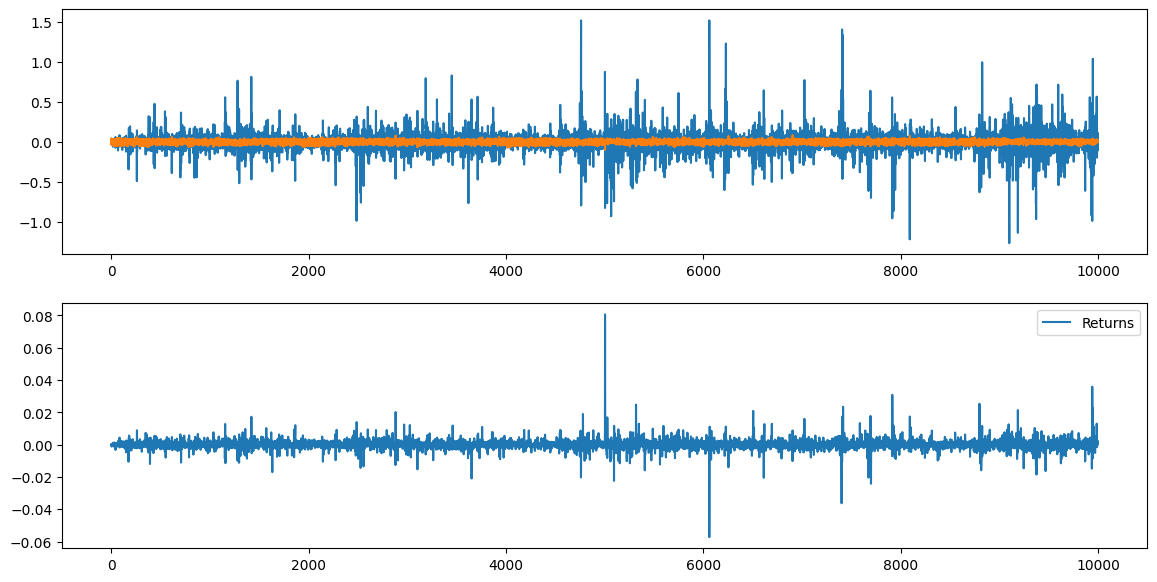

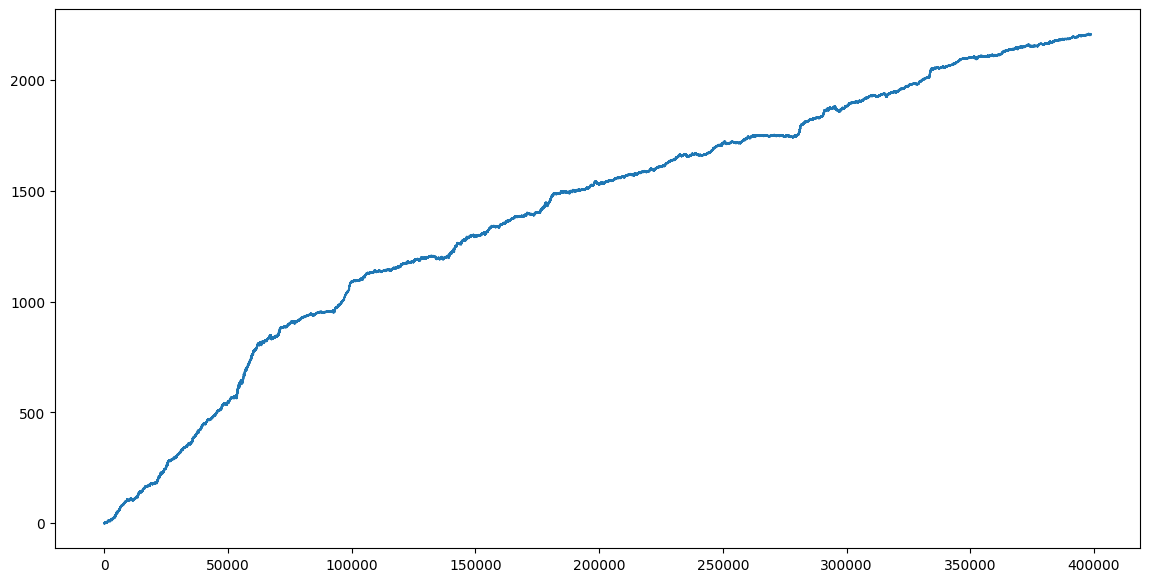

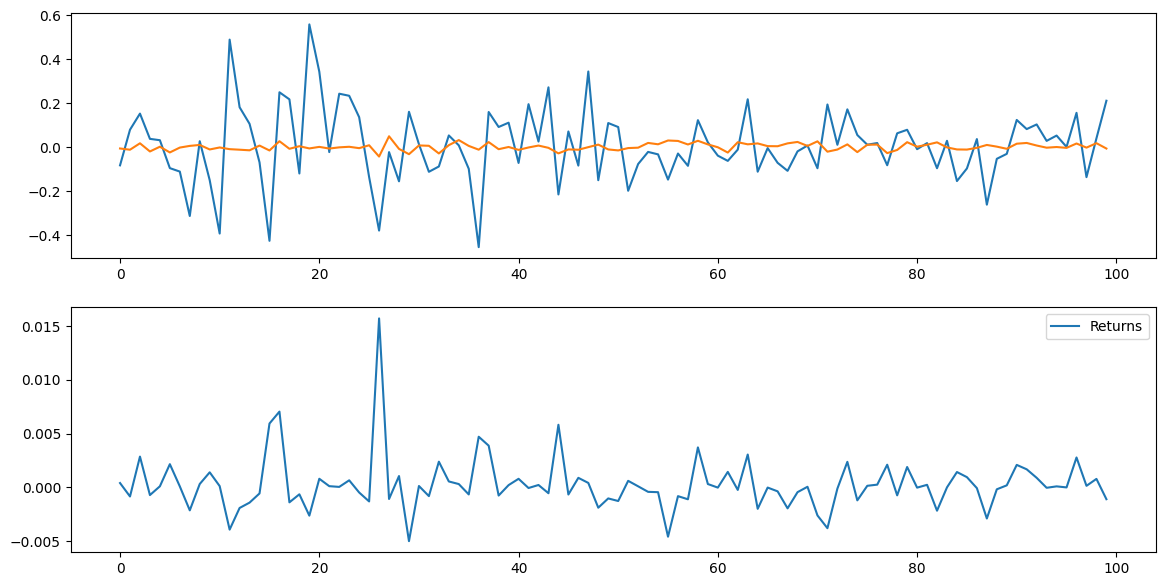

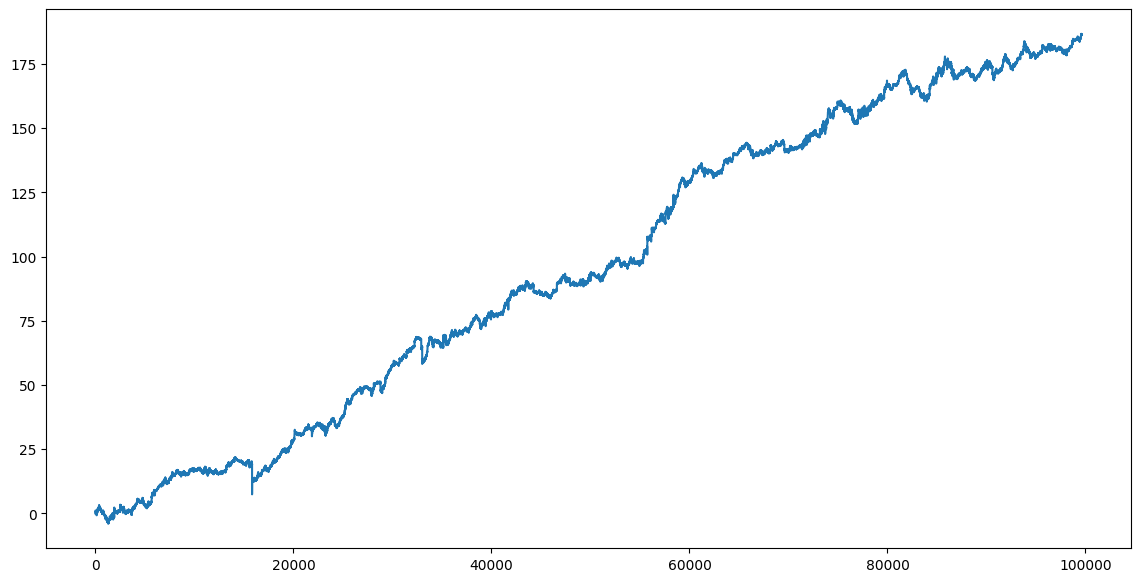

##### TRAIN mse 5.5415E-03 mae 2.4452E-02 r: 1.3550E-04 VALIDATION mse 1.8723E-03 mae 2.2422E-02 r: 4.1979E-05 #####


In [51]:

print('##### TRAIN mse {:.4E} mae {:.4E} r: {:.4E} VALIDATION mse {:.4E} mae {:.4E} r: {:.4E} #####'.format(*eval_epoch(model, train_dataloader_infer, points=10000), *eval_epoch(model, val_dataloader, points=100)))
